# Menu <a class="anchor" id="menu"></a>
* [1. Mise en place](#init)
* [2. Feature Engineering](#feature_engineering)
    * [2.1 Créons quelques features métiers](#feature_engineering_crea)
    * [2.2 Testons l'effet des nouvelles features](#feature_engineering_test)
        * [Logistic Regression](#models_linear_new_features)
        * [XGBoost Classifier](#models_xgboost_new_features)
        * [Revue des scores](#models_new_features_scores)
* [3. Feature Selection](#feature_selection)
    * [3.1 En fonction de l'importance des features dans le modèle (SelectFromModel)](#feature_selection_method1)
    * [3.2 En fonction du score chi2 des features (SelectKBest / chi2)](#feature_selection_method2)
    * [3.3 Par éliminiation récursive des features (RFECV)](#feature_selection_method3)
    * [3.4 Par comparaison avec les importance nulles](#feature_selection_method4)
    * [3.5 Testons l'effet de la selection](#feature_selection_test)
        * [Logistic Regression](#models_linear_features_selection)
        * [XGBoost Classifier](#models_xgboost_features_selection)
        * [Revue des scores](#models_features_selection_scores)
* [4. Création d'une mesure adaptée au métier](#custom_metric)
    * [4.1 F-measure](#custom_metric_solution)
    * [4.2 Testons l'effet de la nouvelle metric](#custom_metric_test)
        * [Logistic Regression](#models_linear_custom_metric)
        * [XGBoost Classifier](#models_xgboost_custom_metric)
        * [Revue des scores](#models_custom_metric_scores)
* [5. Augmentation du training-set](#extra_data)
    * [5.1 Entrainons et testons le modèle final](#final_model)
* [6. Interpretation](#interpretation)
    * [6.1 Interpretation globale](#interpretation_globale)
    * [6.2 Interpretation locale](#interpretation_locale)

# 1. Mise en place <a class="anchor" id="init"></a> [⇪](#menu)

### Chargeons les librairies utiles

In [1]:
import time
import copy as cp
from collections import defaultdict
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly_express as px

random_seed = 0
np.random.seed(random_seed) # Seed the unexpected randomness of this world

import warnings
warnings.filterwarnings('ignore')

import gc
gc.enable()

### Chargons le jeu de données

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [3]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    #usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_train.shape

(307511, 122)

### Faisons quelques réglages pour mieux voir les DataFrames pandas

In [4]:
pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

### Supprimons les colonnes que nous savons inutiles

In [5]:
data_application_train.drop(['SK_ID_CURR', 'FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4'], axis=1, inplace=True)
data_application_train.shape

(307511, 116)

### Supprimons les outliers

In [6]:
def clean_outliers(data):
    data['DAYS_EMPLOYED'].mask(data['DAYS_EMPLOYED']>0, np.nan, inplace=True)
    
    for col in ['AMT_INCOME_TOTAL', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_QRT']:
        data[col].mask(data[col] > data[col].quantile(0.99), np.nan, inplace=True)
        
    return data

data_application_train = clean_outliers(data_application_train)

### Réduisons la taille du jeu de données pour les essais préliminaires des différents modèles

In [7]:
sample_size_base = 30000
data_work = data_application_train[:sample_size_base].copy()

In [8]:
data_work.head()

TARGET NAME_CONTRACT_TYPE CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1         Cash loans           M         False             True   
1       0         Cash loans           F         False            False   
2       0    Revolving loans           M          True             True   
3       0         Cash loans           F         False             True   
4       0         Cash loans           M         False             True   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working  Secondary / secondary special   
1          Family    State servant               Higher education   
2   Unaccompanied          Working  Secondary / secondary special   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0  Single / not married  House / apartment                    0.018801   
1               Married  House / apartment                    0.003541   
2  Single / not married  House / apartment                    0.010032   
3        Civil marriage  House / apartment                    0.008019   
4  Single / not married  House / apartment                    0.028663   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0       -9461         -637.0            -3648.0            -2120          NaN   
1      -16765        -1188.0            -1186.0             -291          NaN   
2      -19046         -225.0            -4260.0            -2531         26.0   
3      -19005        -3039.0            -9833.0            -2437          NaN   
4      -19932        -3038.0            -4311.0            -3458          NaN   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

  OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0        Laborers              1.0                     2   
1      Core staff              2.0                     1   
2        Laborers              1.0                     2   
3        Laborers              2.0                     2   
4      Core staff              1.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                  WEDNESDAY   
1                            1                     MONDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                   THURSDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                   

### Définissons les fonctions permettant de préparer le jeu de données

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler #, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [10]:
def fit_labels(data):
    """ Prepare the encoder for the categorical columns.
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    # Define columns
    oe_targets = [x for x in ['NAME_EDUCATION_TYPE', 'WEEKDAY_APPR_PROCESS_START'] if x in data.columns]
    ohe_targets = [x for x in data.select_dtypes(exclude='number').columns if x not in oe_targets]
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_model):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

In [11]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    
    return dt

In [12]:
def fit_normalizer(data):
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [13]:
def prepare_dataset(data):
    X_full = data.copy()
    
    # Split the dataset
    Y_full = X_full['TARGET']
    X_full.drop(['TARGET'], axis=1, inplace=True)
    
    X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)
    
    print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")
    
    # Encode the categorical variables
    oe_model, ohe_model = fit_labels(X_train)
    X_train = transform_labels(X_train, oe_model, ohe_model)
    X_test = transform_labels(X_test, oe_model, ohe_model)
    
    # Imput missing values
    imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)
    X_train = impute(X_train, imputer_model)
    X_test = impute(X_test, imputer_model)
    
    # Normalize
    model_scaler = fit_normalizer(X_train)
    X_train = normalize(X_train, model_scaler)
    X_test = normalize(X_test, model_scaler)
    
    return X_train, X_test, y_train, y_test, oe_model, ohe_model, imputer_model, model_scaler

### Définissons quelques fonctions pour faciliter la gestion des scores *(rapports, graphiques, enregistrement)* <a class="anchor" id="models_prepare_metrics"></a> [⇪](#menu)

In [14]:
from sklearn.metrics import accuracy_score,\
                            recall_score,\
                            precision_score,\
                            roc_auc_score, roc_curve, RocCurveDisplay, \
                            classification_report, \
                            confusion_matrix, ConfusionMatrixDisplay, \
                            f1_score, \
                            average_precision_score, \
                            fbeta_score, make_scorer

In [15]:
beta_value = 2
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=beta_value)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [16]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [17]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [18]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [19]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [20]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    custom =  scores.get('custom', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, custom, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [21]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'Custom', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores_tuning.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, alone=False, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'custom': f2_score(y_ref, y_pred),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        if alone == False:
            y_preds[method_name] = y_pred_proba
            y_preds_param = y_preds
        else:
            y_preds_param = {method_name:y_pred_proba}
        print_rocauc(y_ref, y_preds_param)
        print_prauc(y_ref, y_preds_param)

In [22]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [23]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)

        if score >= best_score:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [24]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # --> GridSearchCV trop lent

def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, random_state=random_seed)#, refit=refit_scoring)
    #grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=0)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{str(scoring).upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{str(scoring).upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [25]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

### Définissons la méthode de cross-validation utilisée pour tous les tests

In [26]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# 2. Feature Engineering<a class="anchor" id="feature_engineering"></a> [⇪](#menu)

## Créons quelques features métiers<a class="anchor" id="feature_engineering_crea"></a> [⇪](#menu)
 - j'ai exploré les différentes variables et essayé de créer celles qui me paraissaient logiques,
 - j'ai cherché sur les notebooks utilisant ce dataset pour voir ce qui avait été fait,
 - j'ai essayé celles suggérées par mon mentor.

>#### Quelle fraction du bien convointé représente le montant du crédit ?
>
>> data['FRAC_GOODS_PRICE'] = data.AMT_CREDIT / data.AMT_GOODS_PRICE
>
>#### Quel age (en années) avait le client quand il a obtenu son emploi actuel ?
>
>> data['AGE_EMPLOYEMENT'] = (data.DAYS_BIRTH - data.DAYS_EMPLOYED) / -365
>
>#### Quel montant de revenu est disponible pour chaque membre de la famille ?
>
>> data['INCOME_PER_FAM_MEMBER'] = data.AMT_INCOME_TOTAL / data.CNT_FAM_MEMBERS
>
>#### Combien de demandes de crédits ont été faites au total ?
>
>> data['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data.AMT_REQ_CREDIT_BUREAU_HOUR +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_DAY +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_WEEK +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_MON +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_QRT +\
>>                                            data.AMT_REQ_CREDIT_BUREAU_YEAR
>
>#### Quelle fraction des revenus représente chaque annuité ?
>
>> data['ANNUITY_INCOME_RATIO'] = data.AMT_INCOME_TOTAL / data.AMT_ANNUITY
>
>#### Quel est le reste à payer sur le bien à l'origine de la demande de crédit ?
>
>> data['DIFF_GOOD_PRICE_CREDIT'] = data.AMT_GOODS_PRICE - data.AMT_CREDIT
>
>#### Quel est l'age en années ?
>
>> data['AGE_INT'] = data.DAYS_BIRTH / -365
>
>#### Quelle fraction de son temps de vie représente son dernier emploi ?
>
>> data['DAYS_EMPLOYED_PERC'] = data.DAYS_EMPLOYED / data.DAYS_BIRTH

### Ajoutons ces nouvelles features au dataset de travail

In [27]:
def add_new_features( data ):
    data = data.copy()
    
    data['FRAC_GOODS_PRICE'] = data.AMT_CREDIT / data.AMT_GOODS_PRICE
    data['AGE_EMPLOYEMENT'] = (data.DAYS_BIRTH - data.DAYS_EMPLOYED) / -365
    data['INCOME_PER_FAM_MEMBER'] = data.AMT_INCOME_TOTAL / data.CNT_FAM_MEMBERS
    data['AMT_REQ_CREDIT_BUREAU_TOTAL'] =   data.AMT_REQ_CREDIT_BUREAU_HOUR + data.AMT_REQ_CREDIT_BUREAU_DAY + data.AMT_REQ_CREDIT_BUREAU_WEEK + data.AMT_REQ_CREDIT_BUREAU_MON + data.AMT_REQ_CREDIT_BUREAU_QRT + data.AMT_REQ_CREDIT_BUREAU_YEAR
    data['ANNUITY_INCOME_RATIO'] = data.AMT_INCOME_TOTAL / data.AMT_ANNUITY
    data['DIFF_GOOD_PRICE_CREDIT'] = data.AMT_GOODS_PRICE - data.AMT_CREDIT
    data['AGE_INT'] = data.DAYS_BIRTH / -365
    data['DAYS_EMPLOYED_PERC'] = data.DAYS_EMPLOYED / data.DAYS_BIRTH
    #data['INCOME_CREDIT_PERC'] = data.AMT_INCOME_TOTAL / data.AMT_CREDIT
    #data['PAYMENT_RATE'] = data.AMT_ANNUITY / data.AMT_CREDIT
    
    return data

In [28]:
data_work = add_new_features(data_work)

### Vérifions la corrélation linéaire *(pearson)* des nouvelles features avec TARGET

Pour déterminer si une nouvelle variable est utile, nous pouvons calculer le coefficient de corrélation de Pearson entre cette variable et la cible.

Ce coefficient mesure la force d'une relation linéaire entre deux variables et s'étend de -1 (linéaire parfaitement négatif) à +1 (linéaire parfaitement positif).

Ce n'est pas la meilleure mesure de l'utilité d'une nouvelle variable, mais elle peut donner une première approximation de l'utilité d'une variable pour un modèle d'apprentissage automatique. Plus la valeur du coefficient est élevée, plus un changement dans cette variable est susceptible d'affecter la valeur de la cible. Par conséquent, nous recherchons les variables ayant la plus grande valeur absolue par rapport à la cible.

In [29]:
correlations = data_work.corr(method='pearson')

In [30]:
new_features = [
    'FRAC_GOODS_PRICE', 
    'AGE_EMPLOYEMENT', 
    'INCOME_PER_FAM_MEMBER', 
    'AMT_REQ_CREDIT_BUREAU_TOTAL', 
    'ANNUITY_INCOME_RATIO', 
    'DIFF_GOOD_PRICE_CREDIT', 
    'AGE_INT',
    'DAYS_EMPLOYED_PERC',
    'INCOME_CREDIT_PERC',
    'PAYMENT_RATE',
]

corr_target = correlations.TARGET.sort_values(ascending=False)
for i, (key, value) in enumerate(corr_target.iteritems()):
    if key in new_features:
        print(f"{key.rjust(40)} : {value:6.4f}")

                        FRAC_GOODS_PRICE : 0.0636
             AMT_REQ_CREDIT_BUREAU_TOTAL : 0.0188
                   INCOME_PER_FAM_MEMBER : -0.0150
                         AGE_EMPLOYEMENT : -0.0207
                  DIFF_GOOD_PRICE_CREDIT : -0.0240
                    ANNUITY_INCOME_RATIO : -0.0288
                      DAYS_EMPLOYED_PERC : -0.0739
                                 AGE_INT : -0.0809


> A-priori elles ne sont pas toutes intéressantes pour notre modèle, mais on ne peut pas prévoir les intéractions plus complexe qu'elles pouraient avoir avec d'autres features avec cette simple mesure. 

## Testons les modèles sélectionnés avec les nouvelles features<a class="anchor" id="feature_engineering_test"></a> [⇪](#menu)

--- 
>#### Voici pour rappel les deux modèles que l'on a choisi d'essayer d'améliorer:
> - la `Balanced LogisticRegression`:
>   - ROC_AUC : 0.7324
>   - F1 : 0.2405
>   - ACCURACY : 0.6716
>   - PRECISION : 0.1475
>   - RECALL : 0.6500
>   - AVERAGE_PRECISION : 0.2080
> - le `Balanced XGBClassifier`:
>   - ROC_AUC : 0.7212
>   - F1 : 0.2377
>   - ACCURACY : 0.6736
>   - PRECISION : 0.1461
>   - RECALL : 0.6361
>   - AVERAGE_PRECISION : 0.2064

---

### Préparons le jeu de données

In [31]:
X_train, X_test, y_train, y_test, _, _, _, _ = prepare_dataset(data_work)

X_train: 85.0% | X_test: 15.0%


### Testons l'effet des nouvelles features sur la Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [32]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, loguniform

In [33]:
max_lr_iter = 3000

param_grid_log = [
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [34]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7047
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7210
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7025
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7024
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7001

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7061 (std:0.0082)

----------------------------------------------------------------------------------------------------


In [35]:
grd_log['grid'].best_params_

{'C': 0.09469170308457578,
 'class_weight': 'balanced',
 'l1_ratio': 0.925596638292661,
 'max_iter': 3000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features] ----------------------------------------------------------------

             ROC_AUC : 0.7382
                  F1 : 0.2459
            ACCURACY : 0.6756
           PRECISION : 0.1510
              RECALL : 0.6611
   AVERAGE_PRECISION : 0.2089
              CUSTOM : 0.3946

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.66      0.25       360

      accuracy                           0.68      4500
     macro avg       0.55      0.67      0.52      45

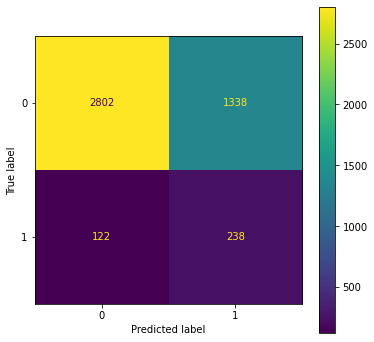

--- ROC AUC ---------------------------------------------------------------------------------------- 



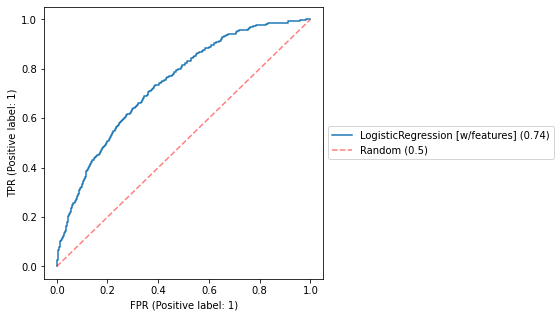

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



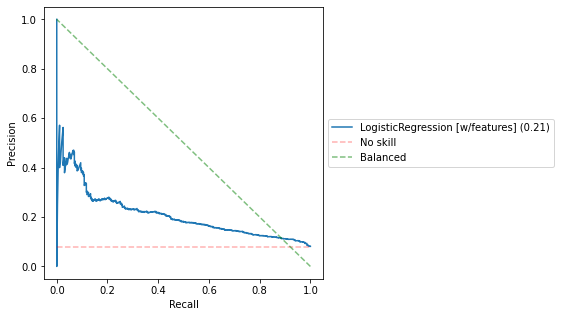

In [36]:
get_scores(f"{model_name} [w/features]", **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [37]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.30545229244114) for this model is reached with a threshold of 0.627


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features] ----------------------------------------------------

             ROC_AUC : 0.7382
                  F1 : 0.2773
            ACCURACY : 0.8136
           PRECISION : 0.2010
              RECALL : 0.4472
   AVERAGE_PRECISION : 0.2089
              CUSTOM : 0.3592

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.85      0.89      4140
Prediction = 1       0.20      0.45      0.28       360

      accuracy                           0.81      4500
     macro avg       0.57      0.65      0.59      45

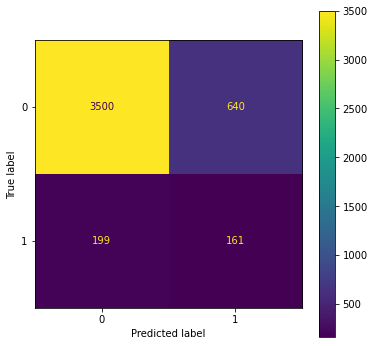

In [38]:
get_scores(f"{model_name} [w/threshold + features]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

### Testons l'effet des nouvelles features sur le XGBoost Classifier<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [39]:
from xgboost import XGBClassifier

In [40]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [41]:
param_grid_xgb = {
    'scale_pos_weight':[scale_weigth],
    'seed':[random_seed],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 20),
    'learning_rate': [None, 0.1, 0.01, 0.05]
}

In [42]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid_xgb,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7219
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7272
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7114
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7147
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7168

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7184 (std:0.0072)

----------------------------------------------------------------------------------------------------


In [43]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'scale_pos_weight': 11.481644640234949,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 60,
 'max_depth': 3,
 'learning_rate': 0.05,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features] ---------------------------------------------------------------------

             ROC_AUC : 0.7211
                  F1 : 0.2391
            ACCURACY : 0.6776
           PRECISION : 0.1474
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.1999
              CUSTOM : 0.3817

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      4140
Prediction = 1       0.15      0.63      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

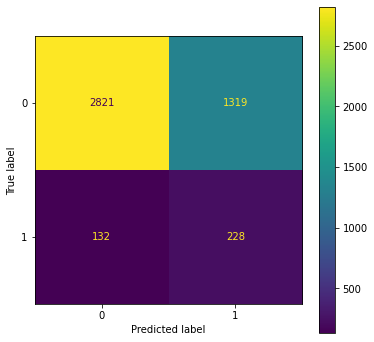

--- ROC AUC ---------------------------------------------------------------------------------------- 



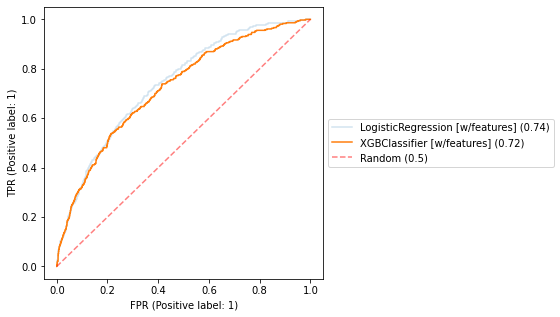

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



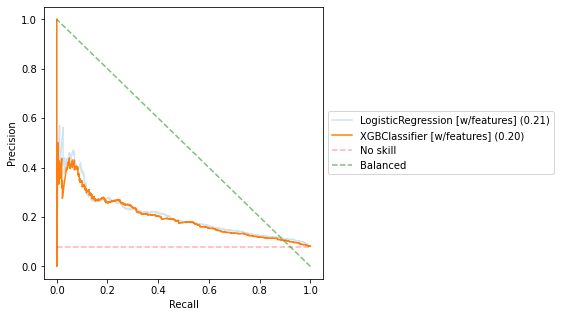

In [44]:
get_scores(f"{model_name} [w/features]", **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [45]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.32255551227113366) for this model is reached with a threshold of 0.633


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/thresholding + features] ------------------------------------------------------

             ROC_AUC : 0.7211
                  F1 : 0.2608
            ACCURACY : 0.8513
           PRECISION : 0.2165
              RECALL : 0.3278
   AVERAGE_PRECISION : 0.1999
              CUSTOM : 0.2972

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.90      0.92      4140
Prediction = 1       0.22      0.33      0.26       360

      accuracy                           0.85      4500
     macro avg       0.58      0.61      0.59      45

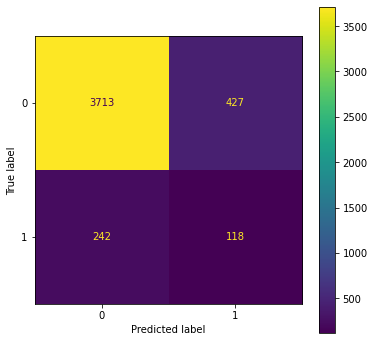

In [46]:
get_scores(f"{model_name} [w/thresholding + features]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

### Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [47]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  Precision    Recall
0  LogisticRegression [w/features]  0.738159  0.245868   0.151015  0.661111
2       XGBClassifier [w/features]  0.721111  0.239119   0.147382  0.633333

In [48]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

Method   ROC AUC  F1 score  Precision  \
1  LogisticRegression [w/threshold + features]  0.738159  0.277347   0.200999   
3    XGBClassifier [w/thresholding + features]  0.721111  0.260773   0.216514   

     Recall  
1  0.447222  
3  0.327778

#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [49]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
23                   Balanced LogisticRegression  0.732390  0.240493   
24  Balanced LogisticRegression [w/thresholding]  0.732390  0.276182   
29                        Balanced XGBClassifier  0.721245  0.237675   
30       Balanced XGBClassifier [w/thresholding]  0.721245  0.265700   

    Precision    Recall  
23   0.147541  0.650000  
24   0.207232  0.413889  
29   0.146139  0.636111  
30   0.235043  0.305556

### Bilan de la section

> On constate qu'avec les nouvelles features, tous les scores de la LogisticRegression augmentent nettement. C'est cependant moins marqué avec le XGBClassifier; si F1, Accuracy et Precision sont effectivement à la hausse, les autres scores sont stables ou très légèrement à la baisse (de l'ordre de 1e-3 ou 1e-4) avec par exemple un ROC_AUC qui passe de 0.7212 à 0.7211.

> La modification ayant un impact significatif sur la LogisticRegression et un impact pas vraiment négatif sur le XGBClassifier, nous allons utiliser ces nouvelles features pour la suite de nos recherches.

In [50]:
import FreeMobileSMS as sms
sms.send("Feature Engineering - Done", stop=False)

# 3. Feature selection <a class="anchor" id="feature_selection"></a> [⇪](#menu)

> Les trois principaux avantages de la feature selection sont les suivants :
> - **Réduire l'overfitting** : Moins de données redondantes signifie moins de possibilités de prendre des décisions basées sur le bruit.
> - **Amélioration de la précision** : Moins de données trompeuses signifie une amélioration de la précision de la modélisation.
> - **Réduction du temps d'entrainement** : Moins de données signifie que les algorithmes s'entraînent plus rapidement.

> **Note**<br>
> Chaque méthode a été testée, mais j'ai désactivée les premières pour le rendu final car trop longues *(en particulier RFECV)*

## Sélection selon l'importance des features dans un modèle donné <a class="anchor" id="feature_selection_method1"></a> [⇪](#menu)

## Sélection en fonction du score chi2 des features <a class="anchor" id="feature_selection_method2"></a> [⇪](#menu)

## Sélection par élimination récursive des features avec cross-validation <a class="anchor" id="feature_selection_method3"></a> [⇪](#menu)

## Sélection par comparaison avec les importances nulles  <a class="anchor" id="feature_selection_method4"></a> [⇪](#menu)
*(l'importance nulle est l'importance moyenne de chaque feature sans considération pour les valeurs cibles)*

> Cette méthode vient du notebook proposé par un participant à la compétition Kaggle associée à ce dataset.
> https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [51]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [52]:
def get_feature_importances(data, shuffle, categorical_feats, seed=None, ):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4,
        'verbose':-1
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats, verbose_eval=-1)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [53]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc',
        'verbose':-1
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

In [54]:
def nimp_feature_selection(data):
    """
    Feature Selection with Null Importances based on the method of the Kaggle competition winner Olivier Grellier.
    https://www.kaggle.com/code/ogrellier/feature-selection-with-null-importances/comments
    
    - “split” contains numbers of times the feature is used in a model.
    - “gain”, contains total gains of splits which use the feature.
    """
    
    # Encode categorical
    print(" Encoding categorical ".center(100,'-'))
    data = data.copy()
    categorical_feats = [f for f in data.columns if data[f].dtype == 'object']

    for f_ in categorical_feats:
        data[f_], _ = pd.factorize(data[f_])
        data[f_] = data[f_].astype('category')
        
    # Get the actual importance, i.e. without shuffling
    print(" Getting the actual importance ".center(100,'-'))
    actual_imp_df = get_feature_importances(data=data, shuffle=False, categorical_feats=categorical_feats)
    
    # Build Null Importances distribution
    print(" Getting the null importance ".center(100,'-'))
    null_imp_df = pd.DataFrame()
    nb_runs = 80
    start = time.time()
    
    for i in range(nb_runs):
        imp_df = get_feature_importances(data=data, shuffle=True, categorical_feats=categorical_feats)
        imp_df['run'] = i + 1 
        null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
        spent = (time.time() - start) / 60
        print(f"Done with {i+1} of {nb_runs} (Spent {spent:.1f} min)", end='\r')
    print("")
        
    # Search best threshold
    print(" Searching for the best threshold ".center(100,'-'))
    best_split_threshold, best_split_value = None, 0
    best_gain_threshold, best_gain_value = None, 0
    
    correlation_scores = get_scores_B(actual_imp_df, null_imp_df).to_numpy()
    
    for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
        
        split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
        split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
        gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
        gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
        print('Results for threshold %3d' % threshold)
        split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
        print(f'\t SPLIT : {split_results[0]:.6f} +/- {split_results[1]:.6f}')
        gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
        print(f'\t GAIN : {gain_results[0]:.6f} +/- {gain_results[1]:.6f}')
        
        if(split_results[0] > best_split_value):
            best_split_value, best_split_threshold = split_results[0], threshold
        
        if(gain_results[0] > best_gain_value):
            best_gain_value, best_gain_threshold = gain_results[0], threshold
            
    print(f"Best SPLIT : {best_split_value} (thresold: {best_split_threshold})")
    print(f"Best GAIN : {best_gain_value} (thresold: {best_gain_threshold})")
            
    # Select columns
    print(" Selecting the columns ".center(100,'-'))
    if best_gain_value > best_split_value:
        selected_cols = [_f for _f, _, _score in correlation_scores if _score >= best_gain_threshold]
    else:
        selected_cols = [_f for _f, _score, _ in correlation_scores if _score >= best_split_threshold]
        
    print(f"The selection contains {len(selected_cols)} columns\n{selected_cols}")
    
    return actual_imp_df, null_imp_df, selected_cols

In [55]:
import matplotlib.gridspec as gridspec

def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

In [56]:
def get_scores_A(actual_imp_df_, null_imp_df_):
    
    feature_scores = []
    
    for _f in actual_imp_df_['feature'].unique():
        
        f_null_imps_gain = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_gain'].values
        f_act_imps_gain = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_gain'].mean()
        gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid divide by zero
        
        f_null_imps_split = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_split'].values
        f_act_imps_split = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_split'].mean()
        split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid divide by zero
        
        feature_scores.append((_f, split_score, gain_score))
        
    return pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

def get_scores_B(actual_imp_df_, null_imp_df_):
    
    correlation_scores = []
    
    for _f in actual_imp_df_['feature'].unique():
        
        f_null_imps = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_gain'].values
        f_act_imps = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_gain'].values
        gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        
        f_null_imps = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_split'].values
        f_act_imps = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_split'].values
        split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        
        correlation_scores.append((_f, split_score, gain_score))

    return pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

def display_split_gain_importance(scores_df):

    plt.figure(figsize=(16, 16))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
    ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
    ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
    plt.tight_layout()

In [57]:
actual_imp_df, null_imp_df, selected_cols = nimp_feature_selection(data_work)

--------------------------------------- Encoding categorical ---------------------------------------
---------------------------------- Getting the actual importance -----------------------------------
----------------------------------- Getting the null importance ------------------------------------
Done with 80 of 80 (Spent 4.5 min)
--------------------------------- Searching for the best threshold ---------------------------------
Results for threshold   0
	 SPLIT : 0.734884 +/- 0.003506
	 GAIN : 0.734884 +/- 0.003506
Results for threshold  10
	 SPLIT : 0.737909 +/- 0.005351
	 GAIN : 0.737832 +/- 0.004640
Results for threshold  20
	 SPLIT : 0.736960 +/- 0.006301
	 GAIN : 0.739965 +/- 0.007920
Results for threshold  30
	 SPLIT : 0.735097 +/- 0.004711
	 GAIN : 0.735546 +/- 0.006463
Results for threshold  40
	 SPLIT : 0.739043 +/- 0.004132
	 GAIN : 0.738323 +/- 0.005784
Results for threshold  50
	 SPLIT : 0.737278 +/- 0.004463
	 GAIN : 0.736141 +/- 0.006709
Results for threshold  60
	

### Nous pouvons explorer les résultats obtenus avec les méthodes suivantes

#### Par exemple on voit ci-dessous que l'importance de `CODE_GENDER` change très nettement entre les deux distributions. <br>Ce qui laisse supposer que c'est une variable qui devrait utile pour prédire `TARGET`.

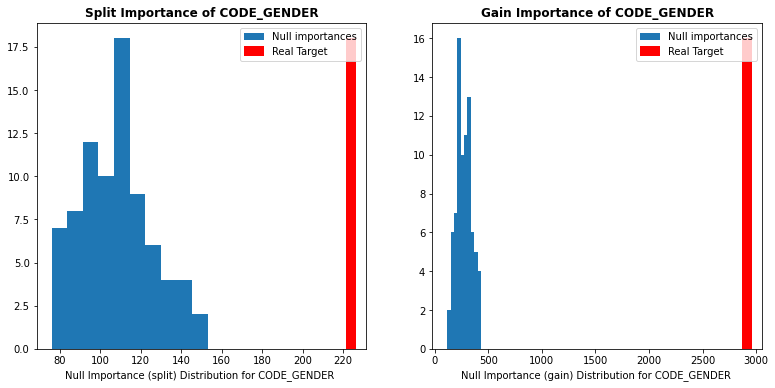

In [58]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

#### Alors qu'à l'inverse l'importance de `FLAG_DOCUMENT_6` est sensiblement la même dans les deux cas. <br>Ce qui tend à laisser penser que cette variable ne sera pas très utile pour aider à prédire `TARGET`.

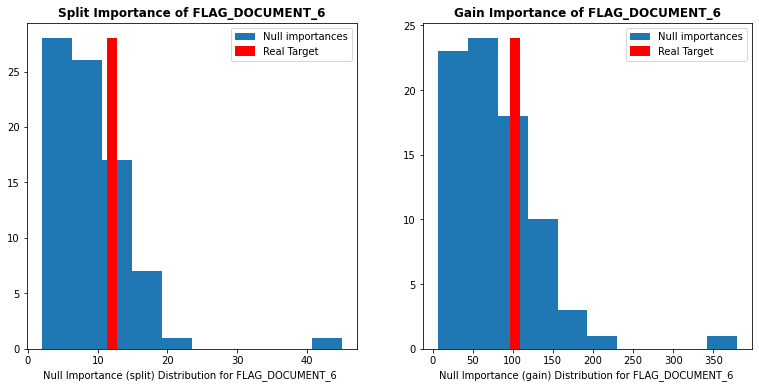

In [59]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='FLAG_DOCUMENT_6')

#### Puis on peut regarder l'importance (en split ou en gain) de chacune des features avant la selection des variables...

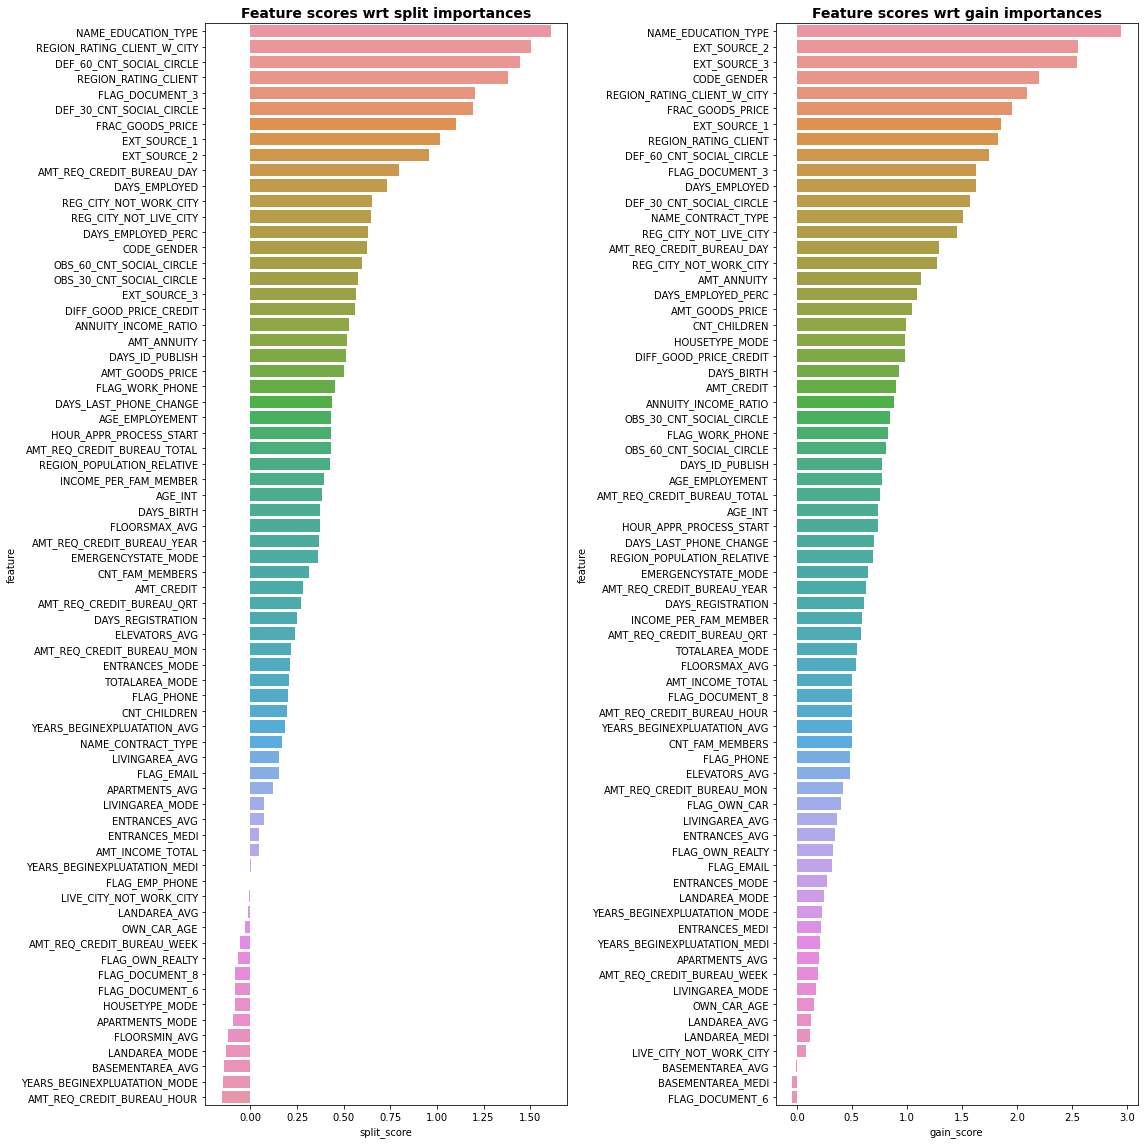

In [60]:
display_split_gain_importance(get_scores_A(actual_imp_df, null_imp_df))

#### ... et après n'avoir gardé que la sélection

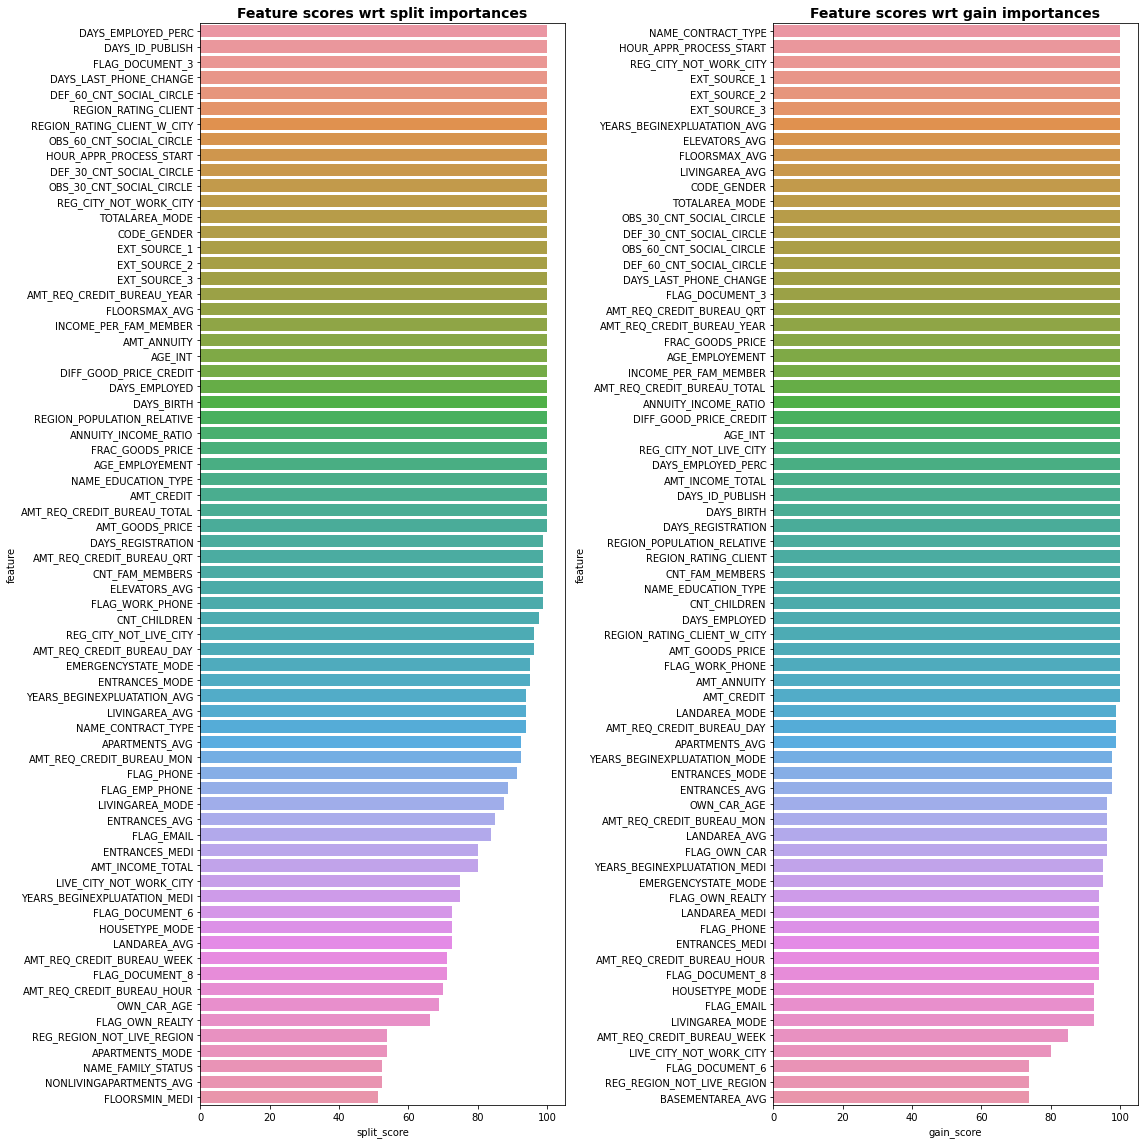

In [61]:
display_split_gain_importance(get_scores_B(actual_imp_df, null_imp_df))

## Testons les modèles sélectionnés avec les features sélectionnées<a class="anchor" id="feature_selection_test"></a> [⇪](#menu)

### Préparons le jeu de données

In [62]:
X_train_s, X_test_s, y_train_s, y_test_s, _, _, _, _ = prepare_dataset(data_work[[*selected_cols, 'TARGET']])

X_train: 85.0% | X_test: 15.0%


### Testons l'effet de la selection sur la Logistic Regression <a class="anchor" id="models_linear_features_selection"></a> [⇪](#menu)

In [63]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,  
    X_ref=X_train_s,
    y_ref=y_train_s,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7041
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7221
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7051
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7113
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7059

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7097 (std:0.0069)

----------------------------------------------------------------------------------------------------


In [64]:
grd_log['grid'].best_params_

{'C': 0.09469170308457578,
 'class_weight': 'balanced',
 'l1_ratio': 0.925596638292661,
 'max_iter': 3000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features + nimp_selection] -----------------------------------------------

             ROC_AUC : 0.7393
                  F1 : 0.2459
            ACCURACY : 0.6729
           PRECISION : 0.1508
              RECALL : 0.6667
   AVERAGE_PRECISION : 0.2108
              CUSTOM : 0.3958

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.67      0.79      4140
Prediction = 1       0.15      0.67      0.25       360

      accuracy                           0.67      4500
     macro avg       0.55      0.67      0.52      45

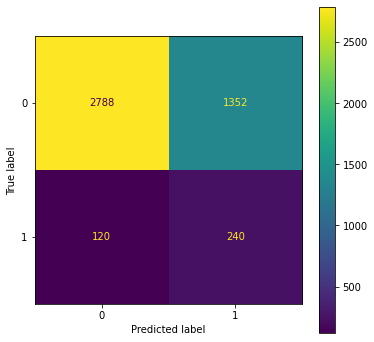

--- ROC AUC ---------------------------------------------------------------------------------------- 



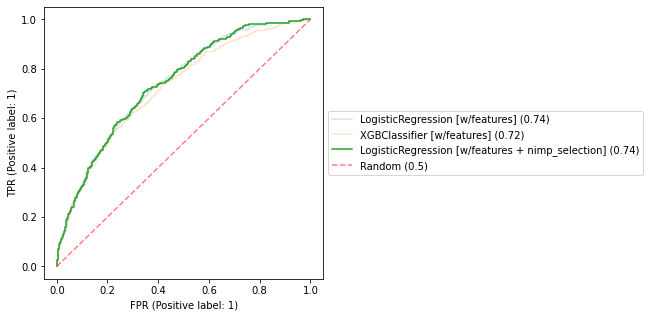

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



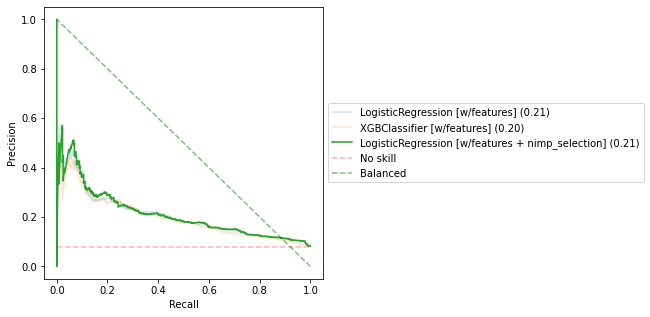

In [65]:
get_scores(f"{model_name} [w/features + nimp_selection]", **grd_log, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [66]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.3045947341249355) for this model is reached with a threshold of 0.652


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features + nimp_selection] -----------------------------------

             ROC_AUC : 0.7393
                  F1 : 0.2746
            ACCURACY : 0.8298
           PRECISION : 0.2083
              RECALL : 0.4028
   AVERAGE_PRECISION : 0.2108
              CUSTOM : 0.3394

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.87      0.90      4140
Prediction = 1       0.21      0.40      0.27       360

      accuracy                           0.83      4500
     macro avg       0.58      0.63      0.59      45

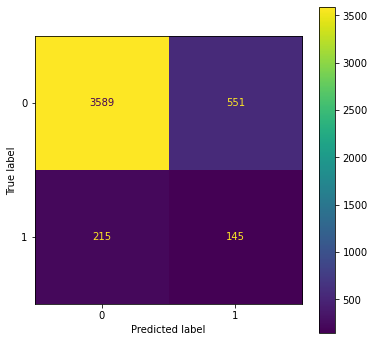

In [67]:
get_scores(f"{model_name} [w/threshold + features + nimp_selection]", **grd_log, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Testons l'effet de la selection sur le XGBoost Classifier<a class="anchor" id="models_xgboost_features_selection"></a> [⇪](#menu)

In [68]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid_xgb,
    X_ref=X_train_s,
    y_ref=y_train_s,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7182
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7271
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7102
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7148
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7185

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7177 (std:0.0073)

----------------------------------------------------------------------------------------------------


In [69]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'scale_pos_weight': 11.481644640234949,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 60,
 'max_depth': 3,
 'learning_rate': 0.05,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features + nimp_selection] ----------------------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2379
            ACCURACY : 0.6753
           PRECISION : 0.1464
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.3804

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.63      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

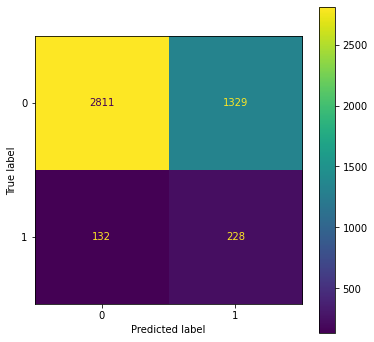

--- ROC AUC ---------------------------------------------------------------------------------------- 



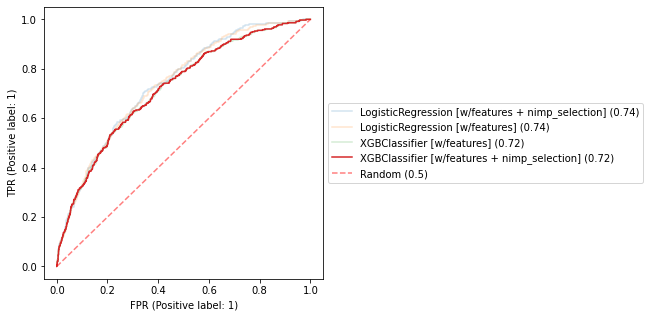

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



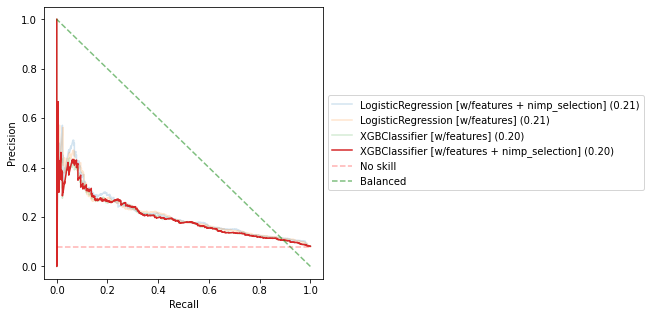

In [70]:
get_scores(f"{model_name} [w/features + nimp_selection]", **grd_xgb, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [71]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.32313883299798796) for this model is reached with a threshold of 0.639


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/threshold + features + nimp_selection] ----------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2647
            ACCURACY : 0.8580
           PRECISION : 0.2259
              RECALL : 0.3194
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.2950

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.90      0.92      4140
Prediction = 1       0.23      0.32      0.26       360

      accuracy                           0.86      4500
     macro avg       0.58      0.61      0.59      45

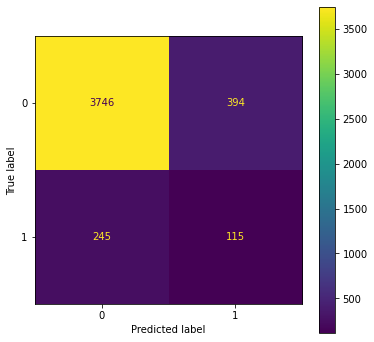

In [72]:
get_scores(f"{model_name} [w/threshold + features + nimp_selection]", **grd_xgb, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Revue des scores <a class="anchor" id="models_features_selection_scores"></a> [⇪](#menu)

In [73]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
0                   LogisticRegression [w/features]  0.738159  0.245868   
2                        XGBClassifier [w/features]  0.721111  0.239119   
4  LogisticRegression [w/features + nimp_selection]  0.739334  0.245902   
6       XGBClassifier [w/features + nimp_selection]  0.721328  0.237872   

   Precision    Recall  
0   0.151015  0.661111  
2   0.147382  0.633333  
4   0.150754  0.666667  
6   0.146435  0.633333

In [74]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

Method   ROC AUC  F1 score  \
1        LogisticRegression [w/threshold + features]  0.738159  0.277347   
3          XGBClassifier [w/thresholding + features]  0.721111  0.260773   
5  LogisticRegression [w/threshold + features + n...  0.739334  0.274621   
7  XGBClassifier [w/threshold + features + nimp_s...  0.721328  0.264672   

   Precision    Recall  
1   0.200999  0.447222  
3   0.216514  0.327778  
5   0.208333  0.402778  
7   0.225933  0.319444

#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [75]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
23                   Balanced LogisticRegression  0.732390  0.240493   
24  Balanced LogisticRegression [w/thresholding]  0.732390  0.276182   
29                        Balanced XGBClassifier  0.721245  0.237675   
30       Balanced XGBClassifier [w/thresholding]  0.721245  0.265700   

    Precision    Recall  
23   0.147541  0.650000  
24   0.207232  0.413889  
29   0.146139  0.636111  
30   0.235043  0.305556

In [76]:
sms.send("Feature selection - Done", stop=False)

### Bilan de la section

> On constate qu'avec la selection de features, le ROC AUC des deux modèles augment légèrement *(par rapport aux scores obtenus avec les nouvelles features)*. On note cependant une lègère baisse sur certains autres scores, mais le Recall et le PR AUC *(qui nous intéressent comme on va le voir plus loin)* sont préservés.

> Nous allons utiliser cette sélection de features pour la suite de nos recherches et tester le modèle final avec et sans cette sélection.

# 4. Création d'une mesure adaptée au métier <a class="anchor" id="custom_metric"></a> [⇪](#menu)

Il est parfois utile de créer une `metric` adaptée aux besoins spécifiques d'un projet.

#### Regardons à quoi correspondent les valeurs de nos matrices de confusion pour nous en rendre compte:
- `(TP) Vrai Positif` : on prédit que le client est à risque, et c'est effectivement le cas. 
> *(on ne prête pas et on **évite une perte**)*

- `(TN) Vrai Négatif` : on prédit que le client n'est PAS à risque, et c'est effectivement le cas.
> *(on prête et on **gagne** de l'argent)*

- `(FP) Faux Positif` : on prédit que le client est à risque, mais ce n'est PAS le cas.
> *(on ne prête pas et on **loupe** de l'argent)*

- `(FN) Faux Négatif` : on prédit que le client n'est PAS à risque, mais ce n'est PAS le cas.
> *(on prête et on **perd** de l'argent)*


 #### Donc nos objectifs par ordre d'importance sont probablement:
> 1. minimiser les `(FN) Faux Négatifs` pour **éviter de perdre de l'argent**.
> 2. maximiser les `(TP) Vrais Positifs` pour **éviter de perdre de l'argent**.
> 3. maximiser les `(TN) Vrais Négatifs` pour **gagner de l'argent**.
> 4. minimiser les `(FP) Faux Positifs` pour **éviter de louper de l'argent**.

 #### Jusqu'à présent nous avons entrainés nos modèles en nous fiant à la mesure de `ROC AUC`.
> Cette metric cherche à maximiser le **taux de vrais positifs** *(TPR | Recall)* et à minimiser le **taux de faux positifs** *(FPR | Anti-specificity)*. C'est un excellent choix si l'on souhaite donner autant d'importance aux classes positives et négatives.

 #### Mais à présent nous aimerions minimiser nos `(FN) Faux Négatifs` et maximiser les `(TP) Vrais Positifs`, ce qui revient en fait à vouloir donner plus d'importance à la classe positive.
> La première solution pour répondre à cet impératif est d'utiliser la mesure `PR AUC` *(Precision Recall Area Under the Curve)* qui cherche à maximiser tout à la fois la **Precision** et le **Recall**.
>
>> RECALL = $\frac{TP}{TP + FN}$
>> - Un haut RECALL favorise les TP.
>> - Un bas RECALL favorise les FN.<br>
>> *Nous avons donc tout intérêt à maximiser notre Recall.*
>
>> PRECISION = $\frac{TP}{TP + FP}$
>> - Une haute PRECISION favorise les TP.
>> - Une basse PRECISION favorise les FP.<br>
>> *Nous avons donc tout intérêt à maximiser notre Precision, mais c'est moins important que le Recall.*

> Pour avoir un peu de contrôle sur le rapport entre *Precision* et *Recall*, on peut se pencher sur la `F-measure` qui se décline sous plusieurs variantes donnant plus ou moins d'importance à l'un ou l'autre. <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)
> * `F0.5-Measure`: donne **plus de poids à la *Precision*** et moins au *Recall*.
> * `F1-Measure`  : donne **autant de poids** à la *Precision* qu'au *Recall*.
> * `F2-Measure`  : donne **plus de poids au *Recall*** qu'à la *Precision*.
>
> Ces metrics sont des version avec un beta-score précis d'une formule plus généraliste appelée Fbeta-Measure et qui permet d'ajuster l'importance donnée à la *Precision* ou au *Recall* en fonction du paramètre beta. Et heureusement pour nous, sklearn met à disposition une version de cette formule appelée [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) que nous allons utiliser.
>
> **Nous voulons donc utiliser cette fonction avec un beta strictement supérieur à 1 pour donner plus de poids au Recall et donc minimiser les FN qui sont potentiellement couteux pour l'organisme de crédit.**

In [77]:
from sklearn.metrics import fbeta_score, make_scorer

In [78]:
# J'ai défini la métrique en début de notebook avec une valeur beta=2 
# pour pouvoir l'utiliser avant cette section

f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=beta_value)
f2_scorer = make_scorer(fbeta_score, beta=beta_value)

## Testons les modèles sélectionnés avec la nouvelle metric<a class="anchor" id="custom_metric_test"></a> [⇪](#menu)

### Testons l'effet de la nouvelle metric sur la Logistic Regression <a class="anchor" id="models_linear_custom_metric"></a> [⇪](#menu)

In [79]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,  
    X_ref=X_train_s, # We use the feature selection
    y_ref=y_train_s,
    cv = skfold,
    scoring=f2_scorer
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3825
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3722
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3567
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3608
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3449

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3634 (std:0.0222)

---------------

In [80]:
grd_log['grid'].best_params_

{'C': 6.735020451500072,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features + custom_metric] ------------------------------------------------

             ROC_AUC : 0.7417
                  F1 : 0.2497
            ACCURACY : 0.6756
           PRECISION : 0.1532
              RECALL : 0.6750
   AVERAGE_PRECISION : 0.2098
              CUSTOM : 0.4015

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.68      0.25       360

      accuracy                           0.68      4500
     macro avg       0.56      0.68      0.52      45

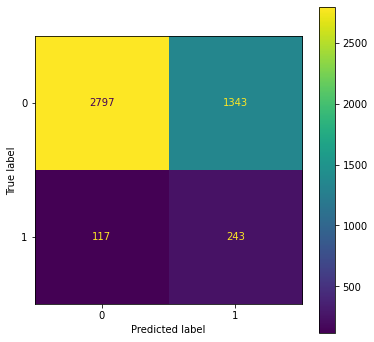

--- ROC AUC ---------------------------------------------------------------------------------------- 



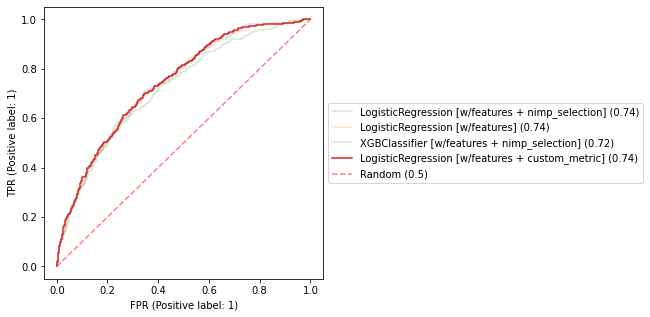

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



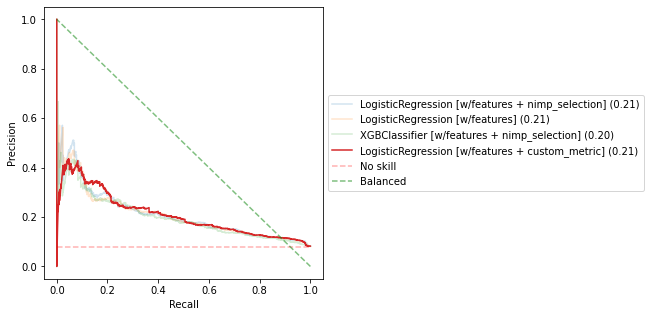

In [81]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_log, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [82]:
f2_value, best_threshold = find_best_threshold(grd_log['model'], X_train_s, y_train_s, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.4217786536138834) for this model is reached with a threshold of 0.528


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features + custom_metric] ------------------------------------

             ROC_AUC : 0.7417
                  F1 : 0.2578
            ACCURACY : 0.7082
           PRECISION : 0.1618
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.2098
              CUSTOM : 0.4001

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.71      0.82      4140
Prediction = 1       0.16      0.63      0.26       360

      accuracy                           0.71      4500
     macro avg       0.56      0.67      0.54      45

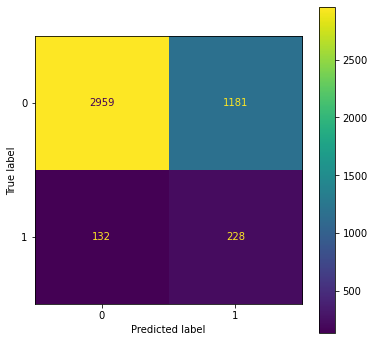

In [83]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_log, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Testons l'effet de la nouvelle metric sur le XGBoost Classifier<a class="anchor" id="models_xgboost_custom_metric"></a> [⇪](#menu)

In [84]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid_xgb,
    X_ref=X_train_s, # We use the feature selection
    y_ref=y_train_s,
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3447
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3433
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3178
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3426
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3210

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3339 (std:0.0138)

---------------

In [85]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'scale_pos_weight': 11.481644640234949,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 60,
 'max_depth': 3,
 'learning_rate': 0.05,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features + custom_metric] -----------------------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2379
            ACCURACY : 0.6753
           PRECISION : 0.1464
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.3804

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.63      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

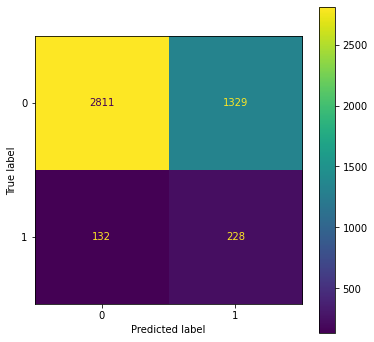

--- ROC AUC ---------------------------------------------------------------------------------------- 



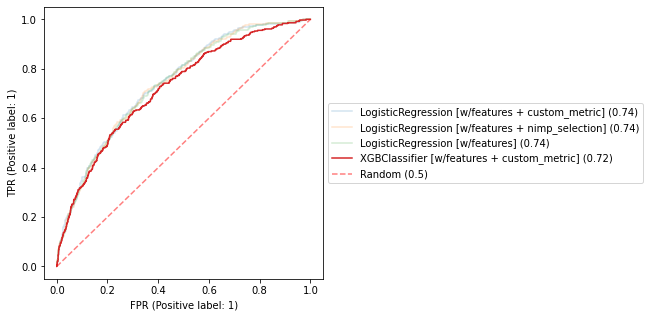

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



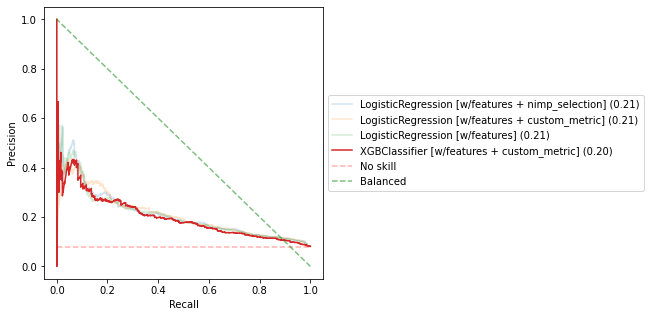

In [86]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_xgb, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [87]:
f2_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train_s, y_train_s, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.42250589704454006) for this model is reached with a threshold of 0.544


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/threshold + features + custom_metric] -----------------------------------------

             ROC_AUC : 0.7213
                  F1 : 0.2638
            ACCURACY : 0.7544
           PRECISION : 0.1735
              RECALL : 0.5500
   AVERAGE_PRECISION : 0.2005
              CUSTOM : 0.3836

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.77      0.85      4140
Prediction = 1       0.17      0.55      0.26       360

      accuracy                           0.75      4500
     macro avg       0.56      0.66      0.56      45

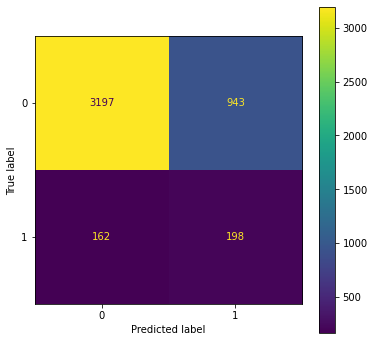

In [88]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_xgb, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

### Revue des scores <a class="anchor" id="models_custom_metric_scores"></a> [⇪](#menu)

#### Les scores obtenus avant les tunings de ce notebook

In [89]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

Method   ROC AUC  F1 score  \
23                   Balanced LogisticRegression  0.732390  0.240493   
24  Balanced LogisticRegression [w/thresholding]  0.732390  0.276182   
29                        Balanced XGBClassifier  0.721245  0.237675   
30       Balanced XGBClassifier [w/thresholding]  0.721245  0.265700   

    Precision    Recall  
23   0.147541  0.650000  
24   0.207232  0.413889  
29   0.146139  0.636111  
30   0.235043  0.305556

#### Tous les modèles entrainés sur ROC AUC sans seuillage

In [90]:
scores_df[ ~(scores_df.Method.str.contains('threshold|custom')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall','Custom']]

Method   ROC AUC  F1 score  \
0                   LogisticRegression [w/features]  0.738159  0.245868   
2                        XGBClassifier [w/features]  0.721111  0.239119   
4  LogisticRegression [w/features + nimp_selection]  0.739334  0.245902   
6       XGBClassifier [w/features + nimp_selection]  0.721328  0.237872   

   Precision    Recall    Custom  
0   0.151015  0.661111  0.394562  
2   0.147382  0.633333  0.381654  
4   0.150754  0.666667  0.395778  
6   0.146435  0.633333  0.380380

#### Tous les modèles entrainés sur ROC AUC avec seuillage

In [91]:
scores_df[ ~(scores_df.Method.str.contains('custom')) & (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall', 'Custom']]

Method   ROC AUC  F1 score  \
1        LogisticRegression [w/threshold + features]  0.738159  0.277347   
3          XGBClassifier [w/thresholding + features]  0.721111  0.260773   
5  LogisticRegression [w/threshold + features + n...  0.739334  0.274621   
7  XGBClassifier [w/threshold + features + nimp_s...  0.721328  0.264672   

   Precision    Recall    Custom  
1   0.200999  0.447222  0.359215  
3   0.216514  0.327778  0.297229  
5   0.208333  0.402778  0.339419  
7   0.225933  0.319444  0.295023

#### Tous les modèles entrainés sur F2-Measure

In [92]:
scores_df[ (scores_df.Method.str.contains('custom')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall', 'Custom']]

Method   ROC AUC  F1 score  \
8     LogisticRegression [w/features + custom_metric]  0.741749  0.249743   
9   LogisticRegression [w/threshold + features + c...  0.741749  0.257773   
10         XGBClassifier [w/features + custom_metric]  0.721328  0.237872   
11  XGBClassifier [w/threshold + features + custom...  0.721328  0.263824   

    Precision    Recall    Custom  
8    0.153216  0.675000  0.401520  
9    0.161817  0.633333  0.400140  
10   0.146435  0.633333  0.380380  
11   0.173532  0.550000  0.383572

### Bilan de la section

> Le modèle LogisticRegression montre une lègère amélioration de la *Precision* et du *Recall*, <br>alors que le XGBClassifier ne présente aucun changement de score ni dans un sens ni dans l'autre.

> La LogisticRegression à mieux réagi que le XGBClassifier à presque toutes les étapes consistant à améliorer les modèles. **Nous allons donc finalser notre projet avec la LogisticRegression.**

In [93]:
sms.send("New metric - Done", stop=False)

# 5. Augmentation du training-set <a class="anchor" id="extra_data"></a> [⇪](#menu)

Pour diminuer le temps d'exploration des divers modèles, les étapes précédents de ce projet ont été réalisées sur un échantillon de 30000 lignes au lieu des 312000 disponibles.

Maintenant que nous avons un modèle qui nous semble convenir à nos besoins, c'est l'occasion de le ré-entrainer avec un training-set beaucoup plus conséquent, et donc de voir les effets que peuvent provoquer l'apport de nouvelles données d'entrainement.

## Préparons donc les training et testing sets sur la base de l'ensemble du dataset

In [94]:
data_work = data_application_train.copy()

#### Ajoutons les `nouvelles features` au dataset complet

In [95]:
data_work = add_new_features(data_work)

#### Séparons le jeu de données en `train` et `test `

In [96]:
X_train, X_test, y_train, y_test, _, _, _, _ = prepare_dataset(data_work)
X_train_s, X_test_s, y_train_s, y_test_s, _, _, _, _ = prepare_dataset(data_work[[*selected_cols, 'TARGET']])

X_train: 84.9998861829333% | X_test: 15.000113817066707%
X_train: 84.9998861829333% | X_test: 15.000113817066707%


## Entrainons et testons le modèle final avec les colonnes sélectionnées par la feature selection<a class="anchor" id="final_model"></a> [⇪](#menu)

In [97]:
model_name = "Final LogisticRegression"

grd_log_s = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,
    X_ref=X_train_s, # with feature selection
    y_ref=y_train_s,
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3621
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3637
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3995
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3692
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3983

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3786 (std:0.0180)

---------------

In [98]:
grd_log_s['grid'].best_params_

{'C': 0.2317105870400502,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/features + custom_metric + selection] ------------------------------

             ROC_AUC : 0.7559
                  F1 : 0.2655
            ACCURACY : 0.6897
           PRECISION : 0.1641
              RECALL : 0.6947
   AVERAGE_PRECISION : 0.2322
              CUSTOM : 0.4219

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.69      0.80     42403
Prediction = 1       0.16      0.69      0.27      3724

      accuracy                           0.69     46127
     macro avg       0.56      0.69      0.53     461

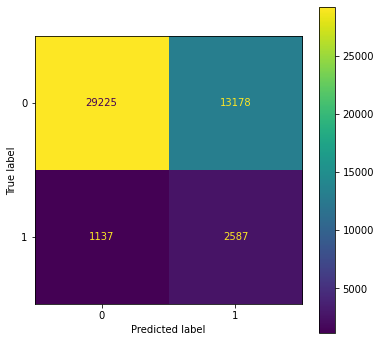

--- ROC AUC ---------------------------------------------------------------------------------------- 



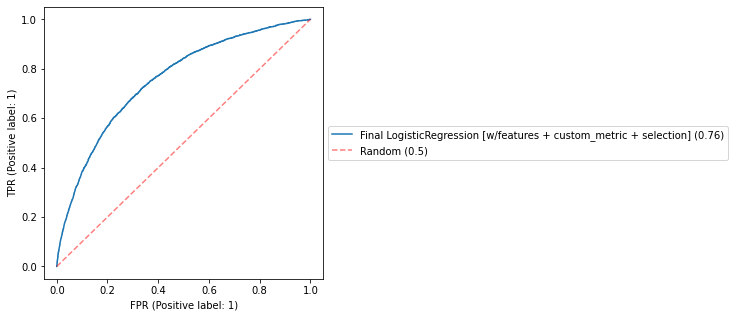

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



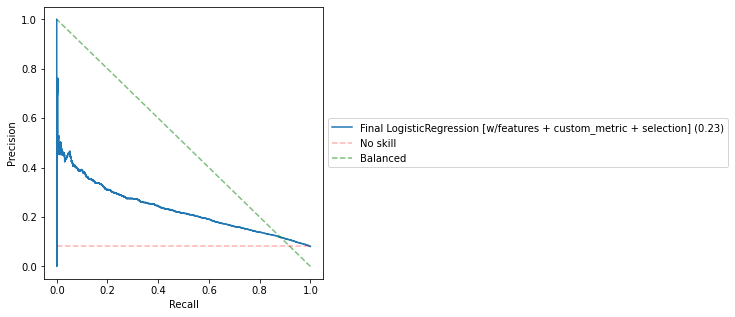

In [99]:
get_scores(f"{model_name} [w/features + custom_metric + selection]", **grd_log_s, X_ref=X_test_s, register=True, alone=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [100]:
f2_value, best_threshold = find_best_threshold(grd_log_s['model'], X_train_s, y_train_s, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.41102700714404766) for this model is reached with a threshold of 0.5


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/threshold + features + custom_metric + selection] ------------------

             ROC_AUC : 0.7559
                  F1 : 0.2655
            ACCURACY : 0.6897
           PRECISION : 0.1641
              RECALL : 0.6947
   AVERAGE_PRECISION : 0.2322
              CUSTOM : 0.4219

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.69      0.80     42403
Prediction = 1       0.16      0.69      0.27      3724

      accuracy                           0.69     46127
     macro avg       0.56      0.69      0.53     461

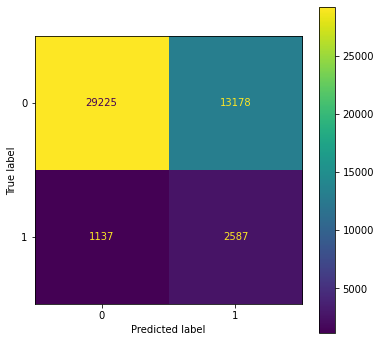

In [101]:
get_scores(f"{model_name} [w/threshold + features + custom_metric + selection]", **grd_log_s, X_ref=X_test_s, threshold=best_threshold, register=True, show_roccurves=False)

## Entrainons et testons le modèle final avec toutes les colonnes<a class="anchor" id="final_model"></a> [⇪](#menu)

In [102]:
model_name = "Final LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid_log,
    X_ref=X_train, # without feature selection
    y_ref=y_train,
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3643
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3642
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3681
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3713
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3692

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3674 (std:0.0028)

---------------

In [103]:
grd_log['grid'].best_params_

{'C': 0.09469170308457578,
 'class_weight': 'balanced',
 'l1_ratio': 0.925596638292661,
 'max_iter': 3000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/features + custom_metric] ------------------------------------------

             ROC_AUC : 0.7574
                  F1 : 0.2683
            ACCURACY : 0.6925
           PRECISION : 0.1660
              RECALL : 0.6982
   AVERAGE_PRECISION : 0.2329
              CUSTOM : 0.4255

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.69      0.81     42403
Prediction = 1       0.17      0.70      0.27      3724

      accuracy                           0.69     46127
     macro avg       0.56      0.70      0.54     461

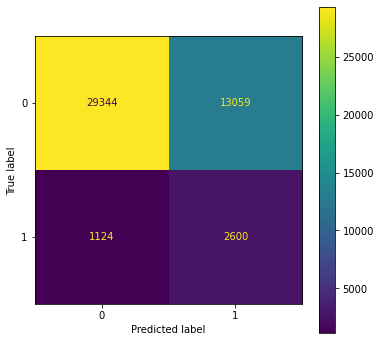

--- ROC AUC ---------------------------------------------------------------------------------------- 



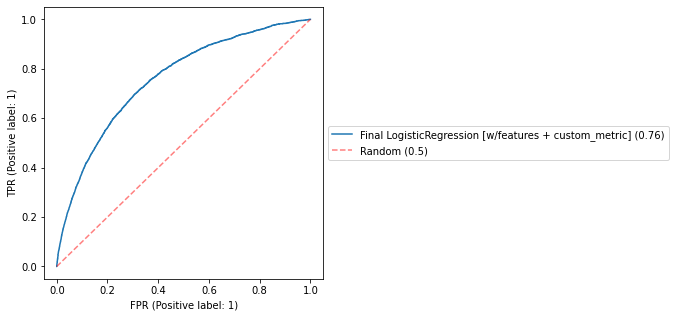

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



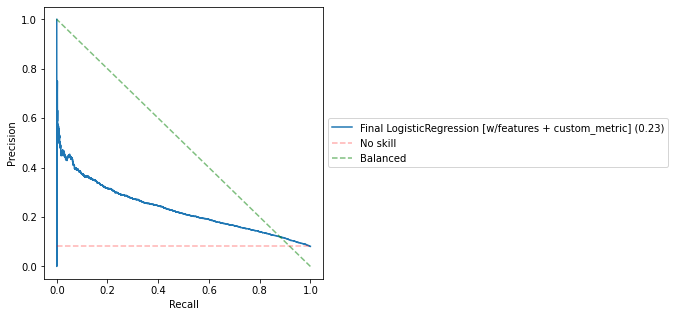

In [104]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_log, X_ref=X_test, register=True, alone=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du Fbeta score)*

In [105]:
f2_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.4128486260939164) for this model is reached with a threshold of 0.509


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Final LogisticRegression [w/threshold + features + custom_metric] ------------------------------

             ROC_AUC : 0.7574
                  F1 : 0.2704
            ACCURACY : 0.7025
           PRECISION : 0.1686
              RECALL : 0.6826
   AVERAGE_PRECISION : 0.2329
              CUSTOM : 0.4240

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.70      0.81     42403
Prediction = 1       0.17      0.68      0.27      3724

      accuracy                           0.70     46127
     macro avg       0.57      0.69      0.54     461

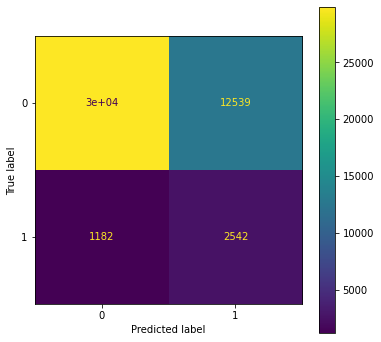

In [106]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_log, X_ref=X_test, threshold=best_threshold, register=True, show_roccurves=False)

In [107]:
y_test_s.value_counts()

0    42403
1     3724
Name: TARGET, dtype: int64

### Bilan de la section

> On constate que l'apport de nouvelles données d'entrainement à **considérablement augmentée plusieurs metrics** (ROC AUC, Precision, Recall, F1_score). C'est dans notre cas le levier qui a l'effet le plus notable.
>
> Les deux modèles avec ou sans Feature selection donnent sensiblement les mêmes résultats. <br>Cependant le modèle avec Feature Selection aurait l'avantage d'être plus légèr à déployer et à expliquer.

In [108]:
sms.send("Full re-train - Done", stop=False)

# 6. Explicabilité du modèle et des résultats <a class="anchor" id="interpretation"></a> [⇪](#menu)

Dans le domaine de l'intelligence artificielle, l’[explicabilité](https://www.cnil.fr/fr/definition/explicabilite) est la capacité de mettre en relation et de rendre compréhensible les éléments pris en compte par le système d’IA pour la production d’un résultat.

Il y a [plusieurs raisons](https://www.aquiladata.fr/insights/shap-mieux-comprendre-linterpretation-de-modeles) pour lesquelles c'est une bonne idée de pouvoir expliquer les résultats d'un modèle:
> - **Aspect légal** : L’article 22 du RGPD prévoit des règles pour éviter qu'un individu ne subisse des décisions émanant uniquement de machines. Les modèles sans explication risquent d’entraîner une sanction qui peut s’élever à 20 000 000 d’euros ou, dans le cas d’une entreprise, à 4% du chiffre d’affaires mondial total de l’exercice précédent (le montant le plus élevé étant retenu),
> - **Validation du modèle** : Le modèle a un bon score sur sa bonne metric, mais nous cherchons à connaître les variables influentes afin de vérifier la cohérence avec la connaissance métier du domaine. D’autre part, pour certaines applications, nous devons également contrôler le risque du modèle, ce qui nécessite une compréhension approfondie de celui-ci,
> - **Explication et recommandation** : Dans notre projet de demande de crédits à la consommation, il est probable que l'on nous demande des explications en cas de refus. Il faut donc pouvoir expliquer au client les raisons du refus et être en capacité de le conseiller pour une futur demande. Inversement, il faut pouvoir motiver une accéptation de crédit auprès de la direction de l'établissement prêteur.

Il existe deux niveaux d'explicabilité qui sont complémentaires et souvent utilisées pour différentes raisons:

> - L'**interpretation globale** qui consiste à définir l’importance des variables du modèle **globalement**. <br>Elle est utile pour vérifier la cohérence du modèle avec les connaissances métiers.
> - L'**interpretation locale** qui consiste à extraire des informations locales **pour des exemples spécifiques** de notre dataset. <br>Elle permet d'exliquer une décision (refus ou acceptation) à un client ou à un supérieur.

Pour nous aider à faire ces intérprétations, nous allons utiliser la librairie SHAP.

> **SHAP** *(SHapley Additive exPlanations)* est une approche de la théorie des jeux pour expliquer la sortie de tout modèle de machine learning. Elle relie l'allocation optimale de crédits aux explications locales en utilisant les *valeurs de Shapley* classiques de la théorie des jeux et leurs extensions connexes. 
>
> L'idée est de répartir équitablement les gains et les coûts entre plusieurs acteurs travaillant en coalition. On utilise cette approche principalement dans les situations où les contributions de chaque acteur sont inégales, mais où chaque acteur travaille en coopération avec les autres pour obtenir le gain ou le paiement final. Elle garantit que chaque acteur gagne autant ou plus que s'il agissait indépendamment. La valeur de Shapley est la contribution marginale moyenne attendue d'un acteur après que toutes les combinaisons possibles aient été considérées.
>
> Dans le cadre du machine learning, on peut utiliser cette méthode pour vérifier de quelle façon les features collaborent et ce qu'elles apportent au résulat final. Ainsi les valeurs de Shapley vont nous donner la contribution marginalle moyenne de chaque feature pour une interprétation globale du modèle et la contribution marginalle pour un example précis pour une intérprétation locale.

In [109]:
import shap

In [110]:
# Linear models

shap_model = grd_log_s['model']

#background = shap.maskers.Partition(X_test_s, max_samples=1000)
#explainer = shap.explainers.Linear(shap_model, masker=background, link=shap.links.logit)
#shap_values = explainer(X_test_s)

def model_proba(x):
    return shap_model.predict_proba(x)[:,1]

def model_log_proba(x):
    p = shap_model.predict_log_proba(x)
    return p[:,1] - p[:,0]

background = shap.maskers.Independent(X_test_s, max_samples=100)
#explainer = shap.Explainer(model_log_proba, background)
explainer = shap.Explainer(shap_model, background)
shap_values = explainer(X_test_s)

## Interprétation globale de modèle  <a class="anchor" id="interpretation_globale"></a> [⇪](#menu)

### Force de l'influence

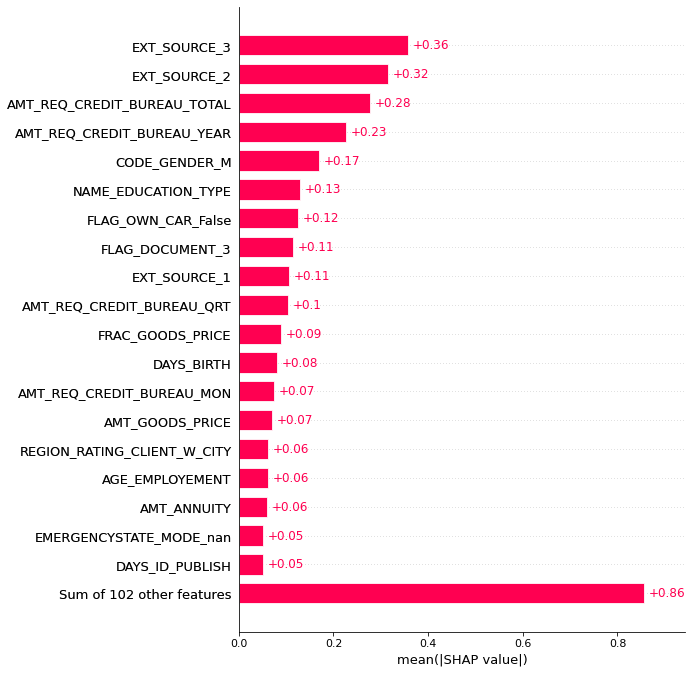

In [112]:
# plot the global importance of each feature
shap.plots.bar(shap_values, max_display=20)

> Ce graphique nous permet de **voir l'influence des variables sur la décision** du modèle pour prédire TARGET.
>
> Ainsi, on constate le modèle retenu place 3 des variables que nous avons fabriqué *(`AMT_REQ_CREDIT_BUREAU_TOTAL`, `FRAC_GOODS_PRICE`, `AGE_EMPLOYEMENT`)* dans son top 20 (dont une dans le top 3).
>
> Cependant, on note que ce sont des valeurs absolues et si l'on peut voir avec quelle force elles influencent les décisions, on ne sait pas dans quel sens elles le font...

### Relation entre les valeurs des variables et leur influence sur le modèle

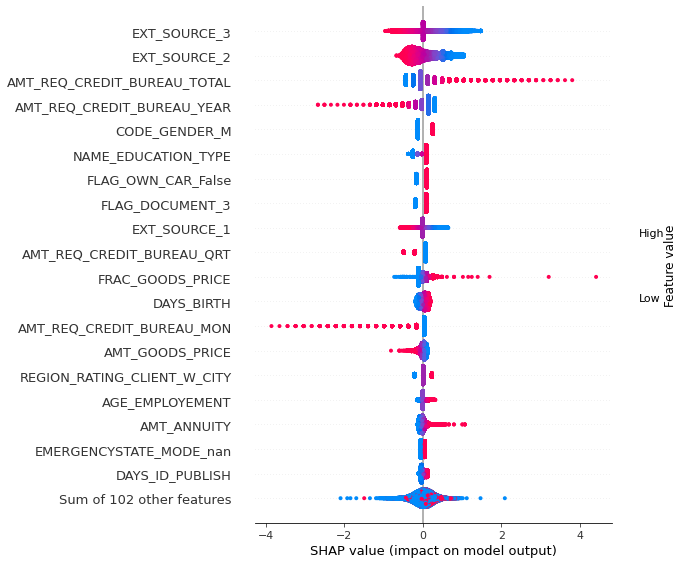

In [113]:
# plot the distribution of importances for each feature over all samples
shap.plots.beeswarm(shap_values, max_display=20)

> Le graphique ci-dessus nous permet de voir plus en détail de quelle façon chaque variable influence le modèle.
> Chaque representation est constituée de nombreux points, et chaque point peut être intereprété comme suit:
> - La *position verticale* indique la feature qu'il représente.
> - La *couleur* indique si l'entrée pour cette feature a une valeur élevée *(rouge)* ou faible *(bleu)*.
> - La *position horizontal* indique si l'effet de cette valeur a entraîné une prédiction plus élevée ou plus faible.

> Ainsi, on constate que les grandes valeurs pour `EXT_SOURCE_3` on tendance à influencer négativement la décision *(donc à augmenter les chance d'obtenir un crédit)*, alors que les faibles valeurs vont influencer positivement la décision *(donc augmenter les chance d'être classifié comme positif et donc de ne pas recevoir le crédit demandé)*.
>
> On peut aussi remarquer avec `FRAC_GOODS_PRICE` que plus le montant de l'object convoité représente une grande fraction du montant demandé pour le crédit et plus ça influence positivement la décision *(donc pousser au refus du crédit)*.
>
> Enfin, on peut noter une étrangeté avec le nombre de demande de crédits, car si le fait d'avoir demandé souvent au cours du dernier moi ou de la dernière année joue positivement pour l'obtention du crédit, le fait d'avoir beaucoup demandé au total semble au contraire être défavorable. On peut supposer que `AMT_REQ_CREDIT_BUREAU_TOTAL` influence surtout par le fait qu'il inclus les demande encore plus récente (semaine, jours...) et que donc une demande trop rapprochée après une précédente demande n'est pas acceuillie favorablement, alors que répéter les demandes mais avec un peu d'écart semble être une bonne approche.

> Il y a beaucoup d'autres informations à tirer ce de graphique...

In [114]:
shap.plots.initjs()
shap.plots.force(shap_values[:500])

> Ce diagramme se compose de nombreux diagrammes de force, dont chacun explique la prédiction d'une instance *(voir plus bas pour un exemple)*. Les diagrammes de force sont pivotés verticalement et regroupés selon divers critères (par défaut selon leur similarité). L'ensemble permet d'identifier d'éventuelles patterns dans le comportement du modèle.

#### Nous pouvons également voir l'influence des valeurs d'une variable sur la décision, de façon plus isolée

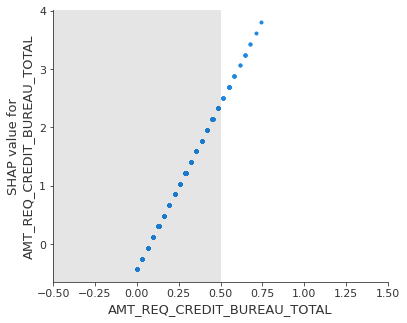

In [115]:
shap.plots.scatter(shap_values[:,"AMT_REQ_CREDIT_BUREAU_TOTAL"])

> Ici nous voyons que plus la valeur de `AMT_REQ_CREDIT_BUREAU_TOTAL` est élévée *(entre 0 et 1 car normalisée)*, plus elle influence positivement la décision *(donc pousse au refus du crédit)*.

## Interprétation locale de modèle  <a class="anchor" id="interpretation_locale"></a> [⇪](#menu)

#### Choisissons un exemple positif auquel on a refusé le crédit *(donc y_pred=1 et y_true=1)*

In [116]:
y_pred = shap_model.predict(X_test_s)

In [117]:
y_true = y_test_s.copy()
y_true.reset_index(drop=True, inplace=True)
y_true[ (y_true == 1) & (y_pred == 1) ].index[:25]

Int64Index([ 27,  38,  57,  79,  81,  88, 113, 146, 148, 191, 197, 203, 206,
            208, 210, 221, 236, 237, 238, 244, 250, 274, 302, 311, 327],
           dtype='int64')

>#### Prenons par exemple le 302

In [118]:
index=302

#### Regardons les probabilités qui lui sont associées

In [119]:
shap_model.predict_proba(X_test_s[index:index+1])

array([[0.16695982, 0.83304018]])

>#### Il est prédit comme positif avec une probabilité de 83%

#### Affichons les valeurs de ses colonnes au cas où...

In [120]:
pd.DataFrame(X_test_s.iloc[index]).T

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
234443                            1.0                                 0.0   

        CODE_GENDER_F  CODE_GENDER_M  CODE_GENDER_nan  FLAG_OWN_CAR_False  \
234443            0.0            1.0              0.0                 1.0   

        FLAG_OWN_CAR_True  FLAG_OWN_REALTY_False  FLAG_OWN_REALTY_True  \
234443                0.0                    0.0                   1.0   

        NAME_INCOME_TYPE_Businessman  NAME_INCOME_TYPE_Commercial associate  \
234443                           0.0                                    0.0   

        NAME_INCOME_TYPE_Maternity leave  NAME_INCOME_TYPE_Pensioner  \
234443                               0.0                         0.0   

        NAME_INCOME_TYPE_State servant  NAME_INCOME_TYPE_Student  \
234443                             0.0                       0.0   

        NAME_INCOME_TYPE_Unemployed  NAME_INCOME_TYPE_Working  \
234443                          0.0                       1.0   

        NAME_FAMILY_STATUS_Civil marriage  NAME_FAMILY_STATUS_Married  \
234443                                0.0                         1.0   

        NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  \
234443                           0.0                                      0.0   

        NAME_FAMILY_STATUS_Widow  NAME_FAMILY_STATUS_nan  \
234443                       0.0                     0.0   

        NAME_HOUSING_TYPE_Co-op apartment  \
234443                                0.0   

        NAME_HOUSING_TYPE_House / apartment  \
234443                                  0.0   

        NAME_HOUSING_TYPE_Municipal apartment  \
234443                                    1.0   

        NAME_HOUSING_TYPE_Office apartment  \
234443                                 0.0   

        NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  \
234443                                 0.0                             0.0   

        HOUSETYPE_MODE_block of flats  HOUSETYPE_MODE_specific housing  \
234443                            0.0                              0.0   

        HOUSETYPE_MODE_terraced house  HOUSETYPE_MODE_nan  \
234443                            0.0                 1.0   

        EMERGENCYSTATE_MODE_False  EMERGENCYSTATE_MODE_True  \
234443                        0.0                       0.0   

        EMERGENCYSTATE_MODE_nan  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
234443                      1.0           0.0          0.446123    0.056067   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_EDUCATION_TYPE  \
234443     0.065321         0.046016                 0.25   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
234443                    0.491595    0.214149         0.9454   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  \
234443           0.900616         0.724746     0.098901             1.0   

        FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
234443              0.0         1.0         0.0         0.052632   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
234443                   0.5                          0.5   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
234443                 0.565217                         0.0   

        REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
234443                         0.0                     0.0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
234443                     0.0                      0.0      0.518178   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
234443      0.293414      0.263638          0.0876            0.0764   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  ELEVATORS_AVG  \
234443                       0.9816           0.7552            0.0   

        ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
234443         0.1379         0.

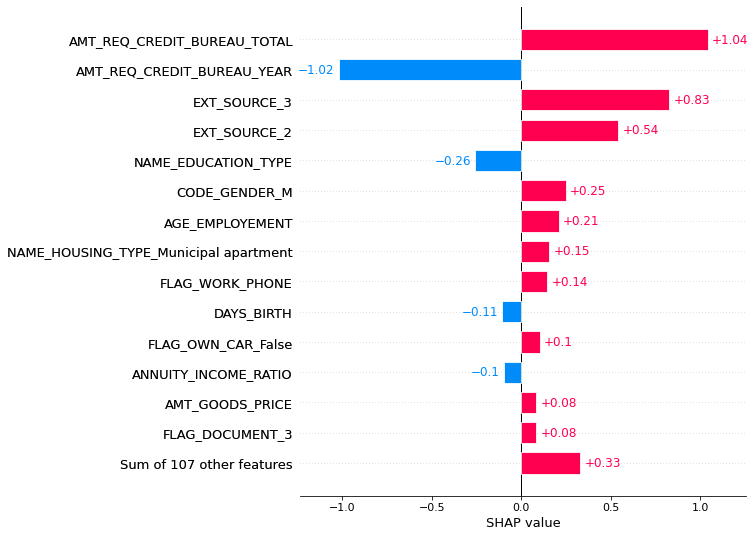

In [121]:
# plot the global importance of each feature for the first prediction
shap.plots.bar(shap_values[index], max_display=15)

> Ces deux graphiques nous permettent de voir de façon sensiblement identiques de quelle façon chaque variable à participé à la prise de décision pour le refus du crédit de ce client.
>
> Ainsi on note que le principal facteur de refus du crédit est `AMT_REQ_CREDIT_BUREAU_TOTAL`, alors que le principal facteur d'accéptation est `AMT_REQ_CREDIT_BUREAU_YEAR`. On peut supposer que le fait qu'il réitère plusieurs fois ses demandes dans l'année est acceulli favorablement, mais qu'au contraire sa dernièe demande doit être trop rapprochée *(_TOTAL inclus les demandes faites au cours du derniers trimestre, alors que _YEAR les exclus)*.
>
> Par ailleurs, on voit également que sont sexe `CODE_GENDER_M` n'est pas un avantage alors que son age `DAYS_BIRTH` ou sont niveau d'éducation `NAME_EDUCATION_TYPE` lui sont favorables.

#### Ci-dessous, deux autres façons de répresenter les mêmes informations, mais qui permettent de voir comment on en arrive à la valeur de décision pas à pas ou par opposition.

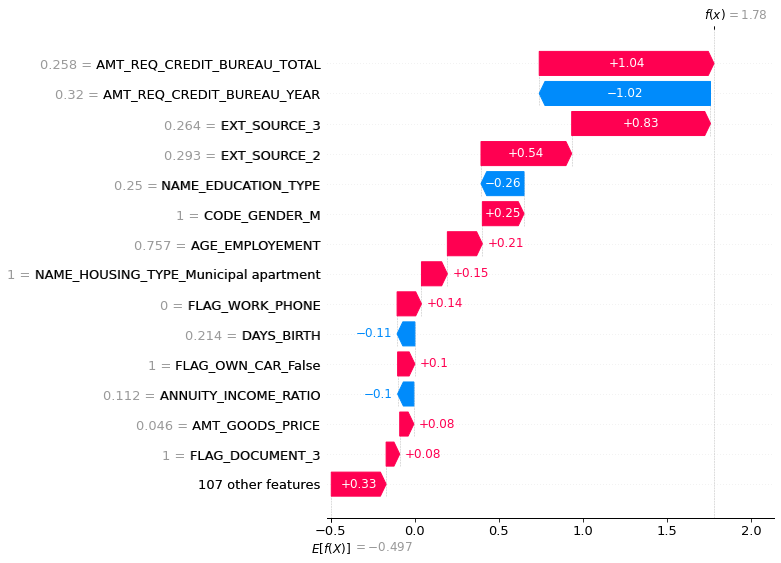

In [122]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[index], max_display=15)

In [138]:
shap.initjs()
# visualize the first prediction's explanation
shap.plots.force(shap_values[index])

> On constate que sur ces deux derniers graphiques le cumul des valeurs pointe sur un f(x) = 1.78, ce qui pourrait paraitre étrange pour une classification binaire dont les valeurs de prédiction oscillent entre 0 et 1.
>
> Mais si l'on applique cette valeur avec la formule de la Regression logistique:<br>$g(z)=\frac{1}{1+e^{-z}}$   on obtient   $g(1.78)=\frac{1}{1+e^{-1.78}} = 0.8557$

In [124]:
shap_model.predict_proba(X_test_s[index:index+1])

array([[0.16695982, 0.83304018]])

> On retrouve donc bien approximativement le pourcentage de prédiction de 0.83%
>
> La différence vient des arrondis des valeurs sur les graphiques et le fait que l'on ai utilisé qu'un échantillon pour calculer les valeurs de Shapley.